In [1]:

import importlib
import shiftNMF_frozen
importlib.reload(shiftNMF_frozen)
from shiftNMF_frozen import ShiftNMF
#from shiftNMFDiscTau import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_ART, X_ART_NOISY, TAU_ART, W_ART, H_ART
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools
from helpers.fit_functions import *
from helpers.plot import *
import torch

# Data

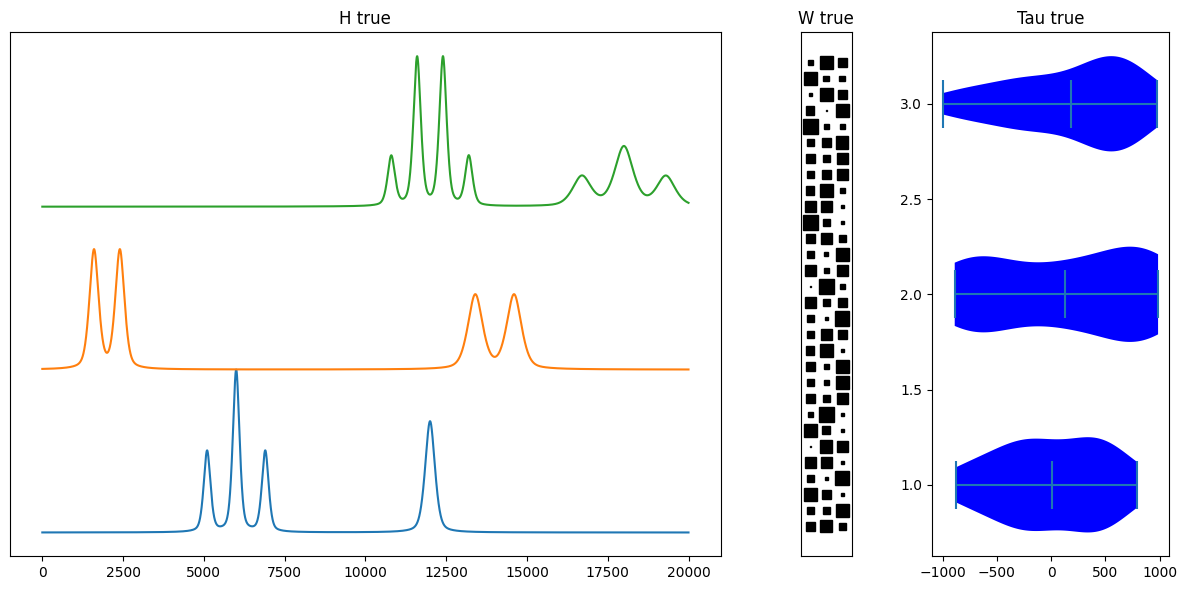

In [2]:
# Create a gridspec object with 2 rows and 3 columns
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X_ART.shape

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_ART.shape[1]), H_ART.T)
ax1.set_title('H true')

ax2 = plt.subplot(gs[1])
ax2.set_title('W true')
hinton(W_ART.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(TAU_ART, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau true')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# shiftNMF

epoch: 500, Loss: 0.06744283885074047, Tau: 6166.7922779999655
Found peaks:[ 2095  2901 13907 15088]
sigma: 162.6822156424615 n:9.443474896243536e-06
sigma: 157.9676891264429 n:3.2782031366113807e-07
sigma: 225.5736294307008 n:0.24979657596160623
sigma: 243.57255945154805 n:6.25844400683103e-07
Lorentzian %:s: 0.028831268740342224
tensor([1.5954e-13, 1.3194e-08, 6.1559e-12, 1.0167e-08],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([164.4782, 158.7984, 239.5988, 245.5791], requires_grad=True)
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}
epoch: 1, Loss: 0.019806448797224947
epoch: 2, Loss: 0.019806448797224947
means:
[ 2498.  14497.5]
sigmas:
[161.6383  242.58897]
J coupling:
[ 806. 1181.]
multiplicity
[2 2]
N
[4.5880837e-11 2.5017702e-10]
W:
[[396.2299   0.       0.       0.     590.0645   0.       0.       0.
    0.    ]]
Found peaks:[ 5077  5986  6887 11981]
si

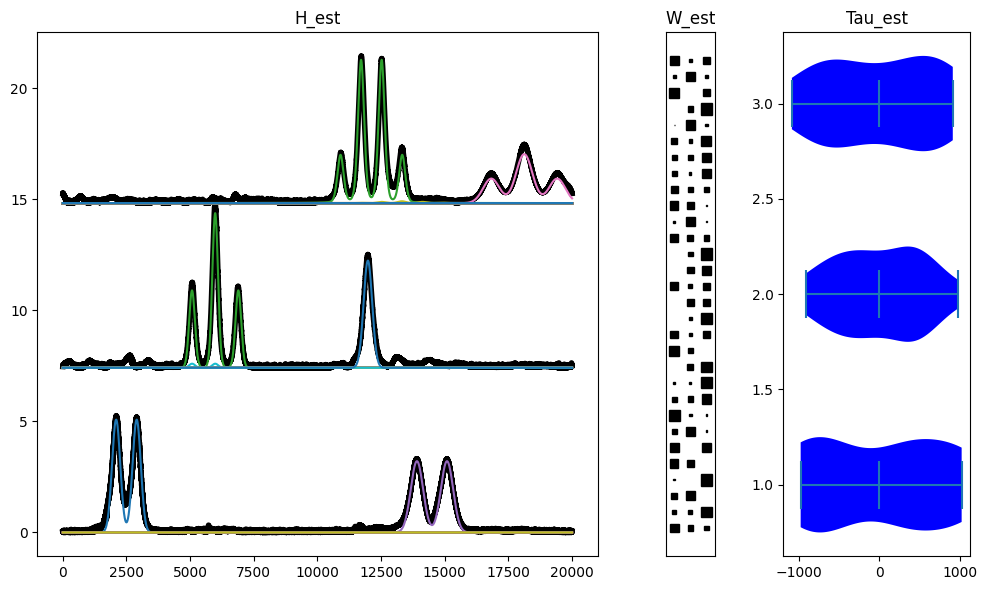

In [2]:

torch.manual_seed(40)

nmf = ShiftNMF(X_ART_NOISY, 3, lr=0.1, alpha=1e-6, patience=30, min_imp=0.001)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=2000, tau_iter=0)

fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []
losses = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i], plot=False)
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)

    W, C, running_loss, path, lambdas, loss = hardmodel.fit(verbose=True, return_loss=True)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    losses.append(loss)
    means, sigma, j_coup, mult, n = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(x,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(x,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

[1.0, 0.7032575658446081, 0.1407578103926332, 0.1398334452753519, 0.13959454503231122, 0.13888379334933168, 0.1385969010088464, 0.1371613731721772, 0.13703552598714702, 0.13695934879298197, 0.13664676587251823, 0.13662285025373822]
[0 4 3 7 5 2 8 6 1]


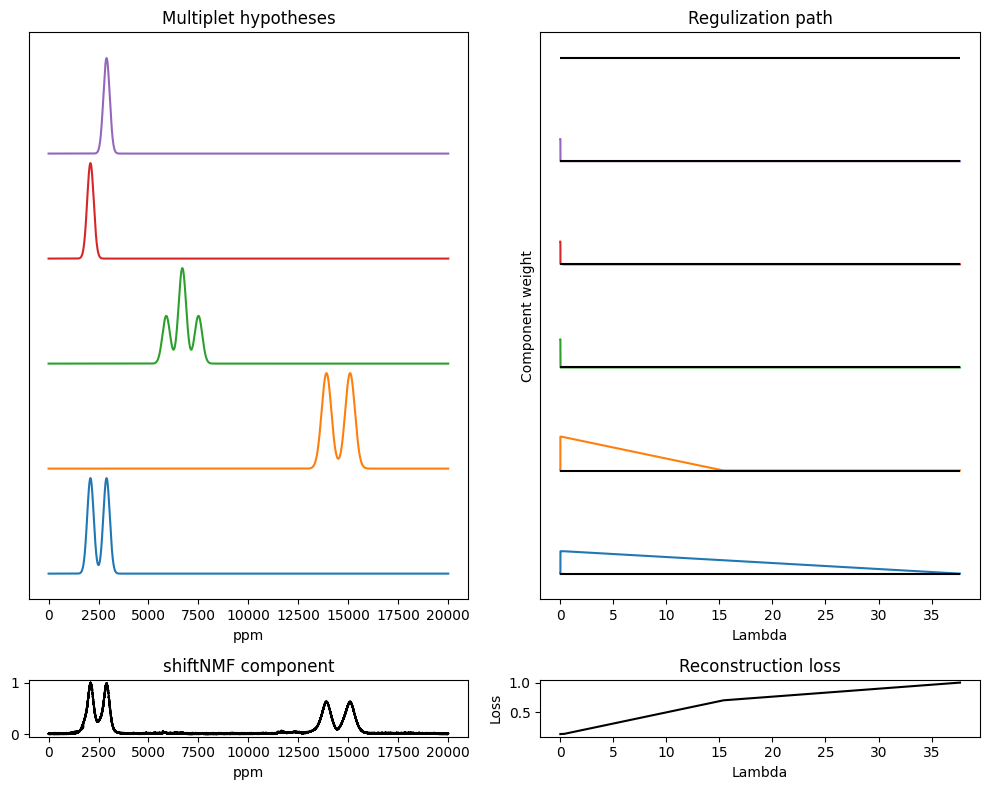

[1.0, 0.9829399167421103, 0.6367240718031242, 0.15037613538633374, 0.14879030437835145, 0.14136063499627893, 0.14125269797829115, 0.14110818635077563, 0.1410270854244259, 0.14102012070995024]
[ 3 11  0  8  7 10  2  5  4  1  6  9]


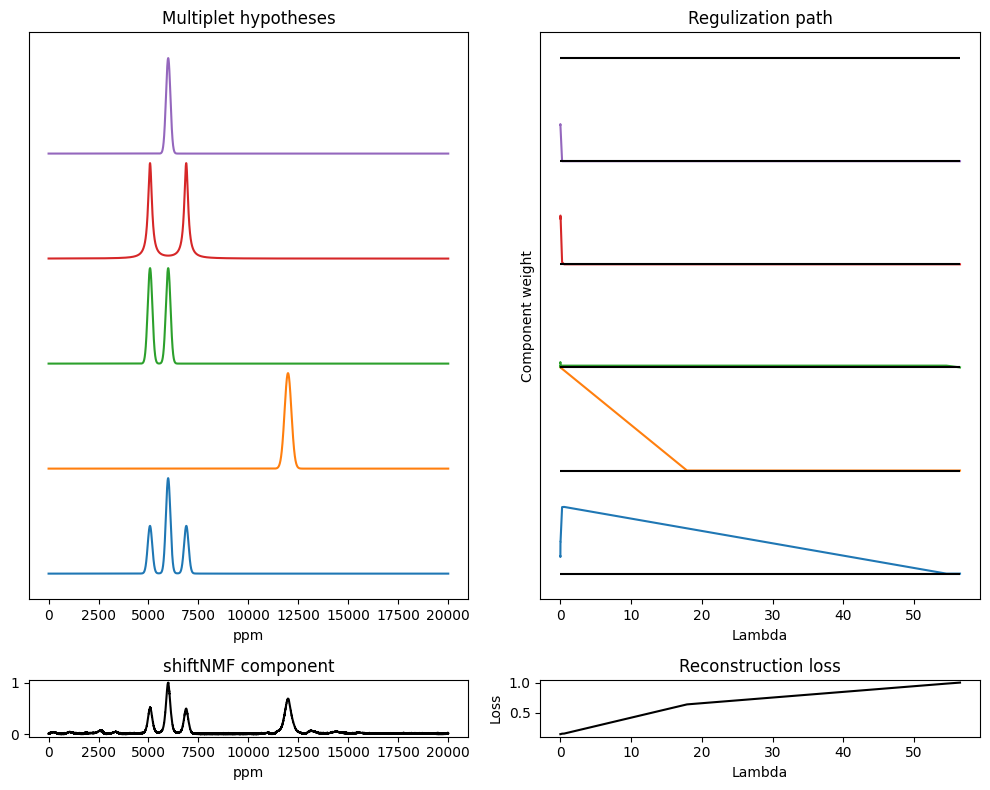

[1.0, 0.48673418867337437, 0.47212139031364986, 0.24282170813107373, 0.15469943145199513, 0.1451845005948987, 0.13839950115382235, 0.1300045657643417, 0.12948490402795798, 0.12491410435830438, 0.10868441740642004, 0.10751327312357921, 0.10684523139291831, 0.10385723663949521, 0.10284587561515528, 0.1025416016913793, 0.10196515028603341, 0.10081459322159192, 0.0998512307895377, 0.09980321285444323, 0.09979773262841495, 0.0983665723202293, 0.09689545220141448, 0.09632769764909917, 0.09236050518923612, 0.09176508762105876, 0.09142285846979167, 0.09119993793395816, 0.09103995530745358, 0.09087369279369595, 0.08970915933459218, 0.08924200550890395, 0.08868500245945249, 0.08827578983454784, 0.08821203931799027, 0.08814530123136963, 0.08804699963123579, 0.08790681584375154, 0.08784229340056221, 0.08782603866060062, 0.08780912756925491, 0.08779762544976573, 0.08770516707295245, 0.08758825193857343, 0.08749940123774848, 0.08747710687915422, 0.08747400931857503, 0.08747362488903607, 0.0874185408

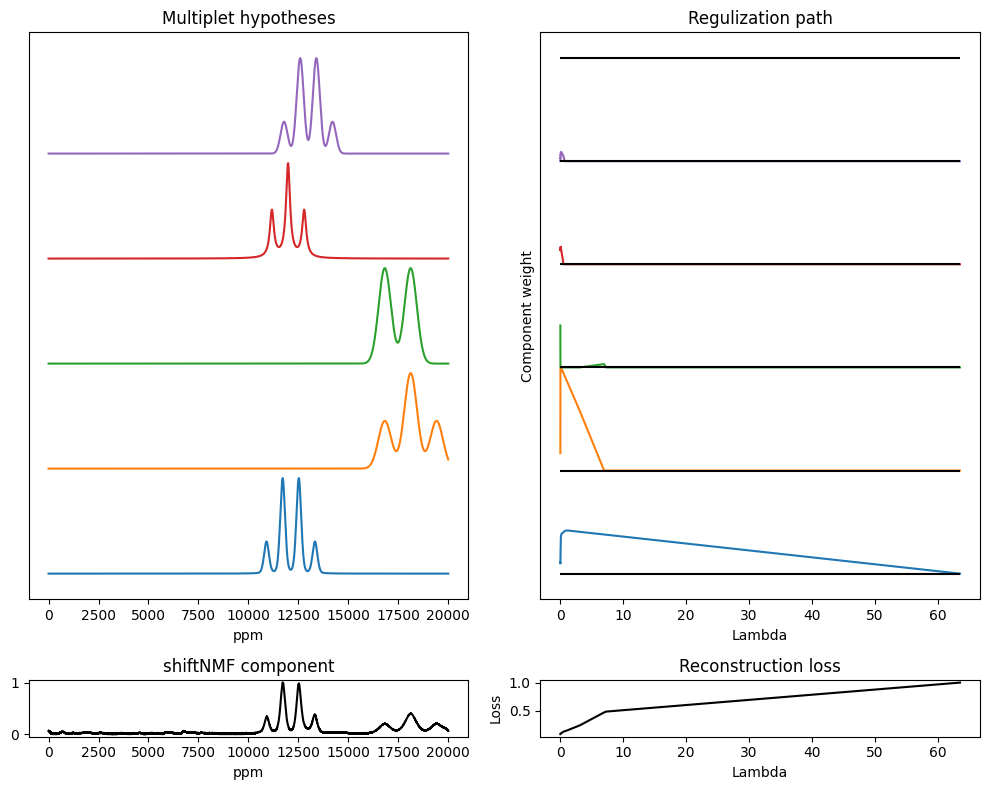

In [36]:

for i in range(len(reg_paths)):
    path = reg_paths[i][0]
    lambdas = lambda_axis[i][0]
    C = C_path[i]
    loss = losses[i]
    print(loss)
    fig = plt.figure(figsize=(10, 8))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[10,1])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regulization path')
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ax3 = plt.subplot(gs[2])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax3.set_title('shiftNMF component')
    ax3.plot(H_est[i]/max(H_est[i]), color="k")
    ax3.set_xlabel("ppm")

    ax4 = plt.subplot(gs[3])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax4.set_title('Reconstruction loss')
    ax4.plot(lambdas, loss, color="k")
    ax4.set_xlabel("Lambda")
    ax4.set_ylabel("Loss")

   
    sort_indices = np.argsort([np.trapz(p,lambdas) for p in path])
    print(sort_indices)
    path = path[sort_indices]
    C = C[sort_indices]

    ymax = 1.1
    yoffset = ymax
    t = 0

    nr_of_components = 5

    for j in range(nr_of_components):
            ax1.plot(x,C[j]/max(C[j])+yoffset*t)
            t += 1

    
    ymax = path.max()
    yoffset = ymax
    t = 0
    for j in range(nr_of_components):
            ax2.plot(lambdas,path[j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")
            t +=1
    ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")


    plt.tight_layout()
    plt.show()

# peak finding (single fit)

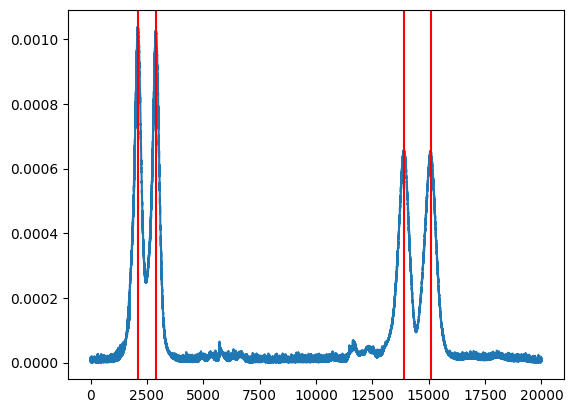

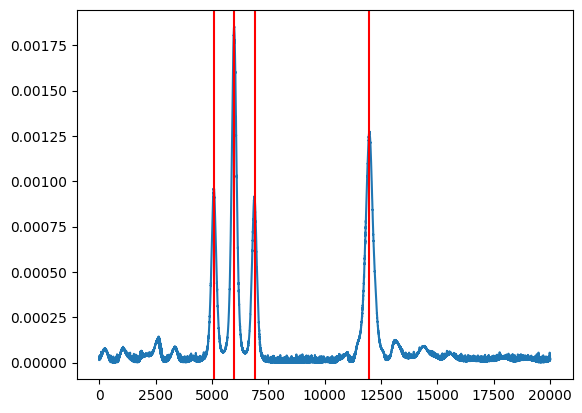

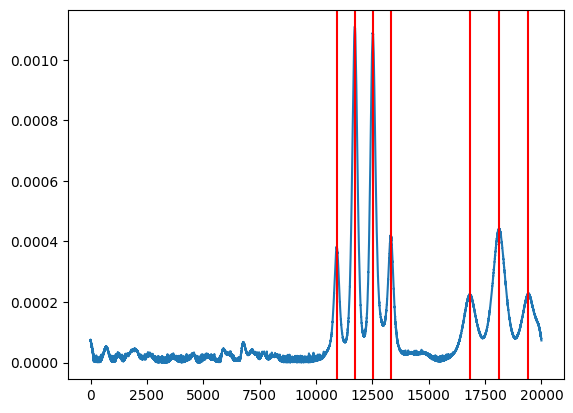

In [5]:

for i in range(len(H_est)):
    plt.plot(H_est[i])
    #peaks = find_peaks_cwt(H_est[i], [100,300])
    peaks = find_peaks(H_est[i], height=max(H_est[i])/10)[0]
    sigmas = scipy.signal.peak_widths(H_est[i], peaks, wlen=1000)[0]/2 #.355*1.5
    select = [sig>100 for sig in sigmas]
    select = [i for i, x in enumerate(select) if x == False]
    sigmas = np.delete(sigmas, select)
    peaks = np.delete(np.array(peaks), select)
    for mean in peaks:
        plt.axvline(mean, color='r')
    plt.show()

# Hardmodel

Found peaks:[ 2095  2901 13907 15088]
sigma: 162.6782571429194 n:9.924028332280397e-06
sigma: 157.98273987114368 n:4.99710560691356e-07
sigma: 225.60692902624422 n:0.24967056814618357
sigma: 243.5767977473962 n:5.66207973291237e-07
Lorentzian %:s: 0.028810020260207618
tensor([1.3190e-13, 9.3324e-09, 6.1536e-12, 1.1097e-08],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([164.4836, 158.8353, 239.5971, 245.6593], requires_grad=True)
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}
tensor(2498.)
torch.Size([1, 20000])
tensor(13907.)
torch.Size([1, 20000])
tensor(6301.)
torch.Size([1, 20000])
tensor(6694.6665)
torch.Size([1, 20000])
tensor(14497.5000)
torch.Size([1, 20000])
tensor(2901.)
torch.Size([1, 20000])
tensor(8497.7500)
torch.Size([1, 20000])
tensor(2095.)
torch.Size([1, 20000])
tensor(15088.)
torch.Size([1, 20000])


TypeError: Hard_Model.fit() got an unexpected keyword argument 'alpha'

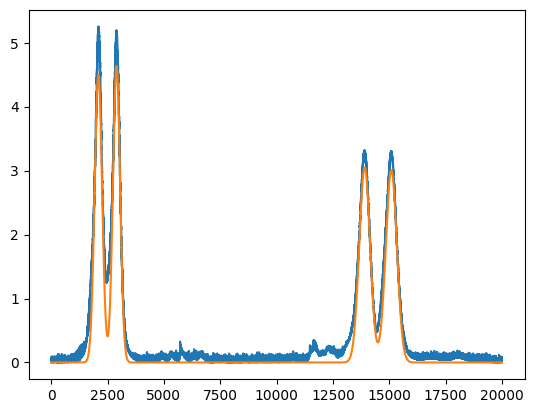

In [7]:
for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i])
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)
    W, C = hardmodel.fit(verbose=True, alpha=0.2)
    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5)

    for i, vec in enumerate(C):
        plt.plot(vec*W[:,i])
    plt.title("C weigthed")
    plt.show()